<a href="https://colab.research.google.com/github/pevu97/Aerial-Object-Classifier/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.set_printoptions(precision=6, suppress=True)

In [4]:
!wget https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5

--2025-07-08 09:48:00--  https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G) [application/octet-stream]
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  4.32MB/s    in 11m 14s 

2025-07-08 09:59:15 (3.87 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



In [5]:
import h5py
import numpy as np
from tensorflow.keras.utils import to_categorical

with h5py.File('Galaxy10_DECals.h5', 'r') as f:
    images = f['images'][:10500]     # tylko 10500 obrazów
    labels = f['ans'][:10500]        # tylko 10500 etykiet



images = images.astype('float32')


In [6]:
print("Kształt labels:", labels.shape)
print("Przykład:", labels[0])


Kształt labels: (10500,)
Przykład: 0


In [7]:
import numpy as np

labels = labels.astype(int)

# oryginalne unikalne klasy:
unique_classes = np.unique(labels)
print("Zachowane klasy:", unique_classes)

# stworzenie mapowania np. {0: 0, 1: 1, 2: 2, 3: 3}
class_map = {old: new for new, old in enumerate(unique_classes)}
print("Mapowanie etykiet:", class_map)

# zastosowanie mapowania
labels_mapped = np.array([class_map[label] for label in labels])


Zachowane klasy: [0 1 2 3 4 5 6]
Mapowanie etykiet: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6}


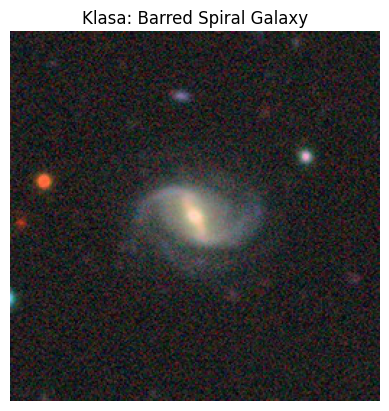

In [8]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "Disturbed", "Merger", "Round Smooth", "In-between Smooth", 'Cigar Shaped Smooth', 'Barred Spiral Galaxy', 'Unbarred Spiral Galaxy'
]


#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 8525 #@param {type:'slider', min:0, max:10000}
label_idx = labels_mapped[idx]
plt.imshow(images[idx].astype(np.uint8))  # obrazy są w formacie uint8
plt.title(f"Klasa: {class_names[label_idx]}")
plt.axis('off')
plt.show()

In [9]:
print("Typ danych:", images[idx].dtype)
print("Zakres wartości:", images[idx].min(), "→", images[idx].max())
print("Kształt:", images[idx].shape)

Typ danych: float32
Zakres wartości: 0.0 → 255.0
Kształt: (256, 256, 3)


In [10]:
df_labels = pd.DataFrame(labels_mapped, columns=['Class number'])
df_labels['Class number'].value_counts().sort_values()

,count
Class number,
4,334
6,517
0,1081
1,1853
3,2027
5,2043
2,2645


In [11]:
import os
from PIL import Image
import numpy as np

# folder docelowy
output_dir = 'sorted_images'
os.makedirs(output_dir, exist_ok=True)

for i, (img, label) in enumerate(zip(images, labels_mapped)):
    label_dir = os.path.join(output_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)

    # zapisz obraz jako JPEG
    img_path = os.path.join(label_dir, f'image_{i:05d}.jpg')
    img_uint8 = img.astype(np.uint8)  # jeśli potrzebne
    Image.fromarray(img_uint8).save(img_path)


In [12]:
import os
import shutil
import random

def split_dataset(source_dir, output_dir, split=(0.7, 0.2, 0.1), seed=42):
    random.seed(seed)
    class_names = os.listdir(source_dir)

    for class_name in class_names:
        src_class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(src_class_dir)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split[0] * n_total)
        n_val   = int(split[1] * n_total)

        split_points = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, file_list in split_points.items():
            dest_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(dest_class_dir, exist_ok=True)

            for fname in file_list:
                shutil.copy2(os.path.join(src_class_dir, fname), os.path.join(dest_class_dir, fname))

# 🔁 Użycie:
split_dataset("sorted_images", "dataset", split=(0.7, 0.2, 0.1))


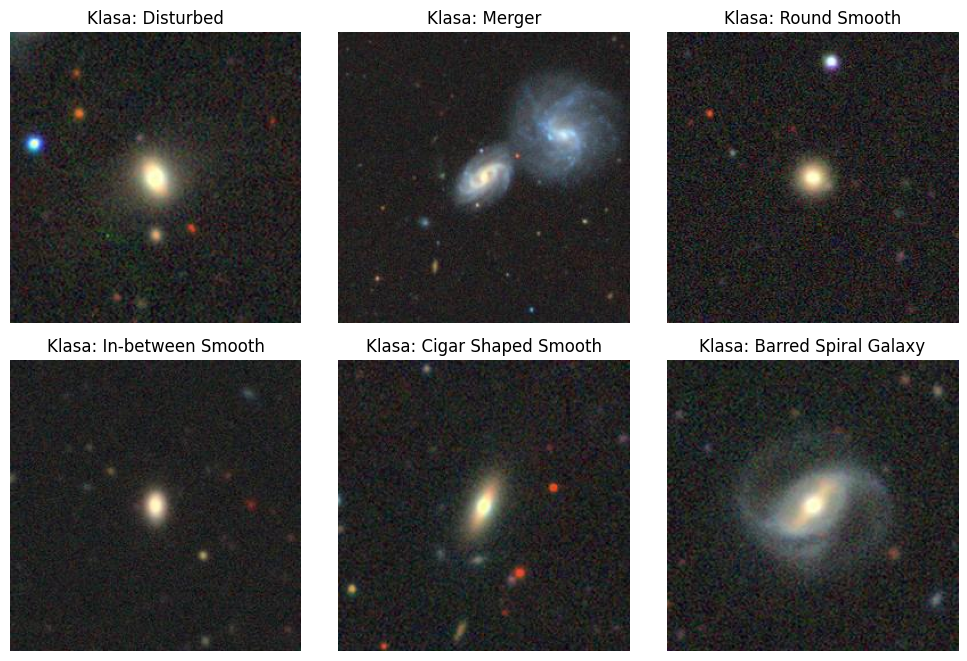

(256, 256)


In [13]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

base_dir = "/content/sorted_images"
class_names = sorted(os.listdir(base_dir))[:6]  # wybierz 4 klasy

plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    image_name = random.choice(os.listdir(class_dir))  # losowe zdjęcie
    image_path = os.path.join(class_dir, image_name)

    img = Image.open(image_path)

    class_labels = {
    '0': 'Disturbed',
    '1': 'Merger',
    '2': 'Round Smooth',
    '3': 'In-between Smooth',
    '4': 'Cigar Shaped Smooth',
    '5': 'Barred Spiral Galaxy',
    '6': 'Unbarred Spiral Galaxy'
    }

    name_tag = class_labels.get(class_name, 'Inna klasa')


    plt.subplot(3, 3,i + 1)
    plt.imshow(img)
    plt.title(f"Klasa: {name_tag}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(img.size)

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255.
)


In [15]:
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/dataset/val',
    target_size=(224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)



Found 7346 images belonging to 7 classes.
Found 2097 images belonging to 7 classes.


In [16]:

def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

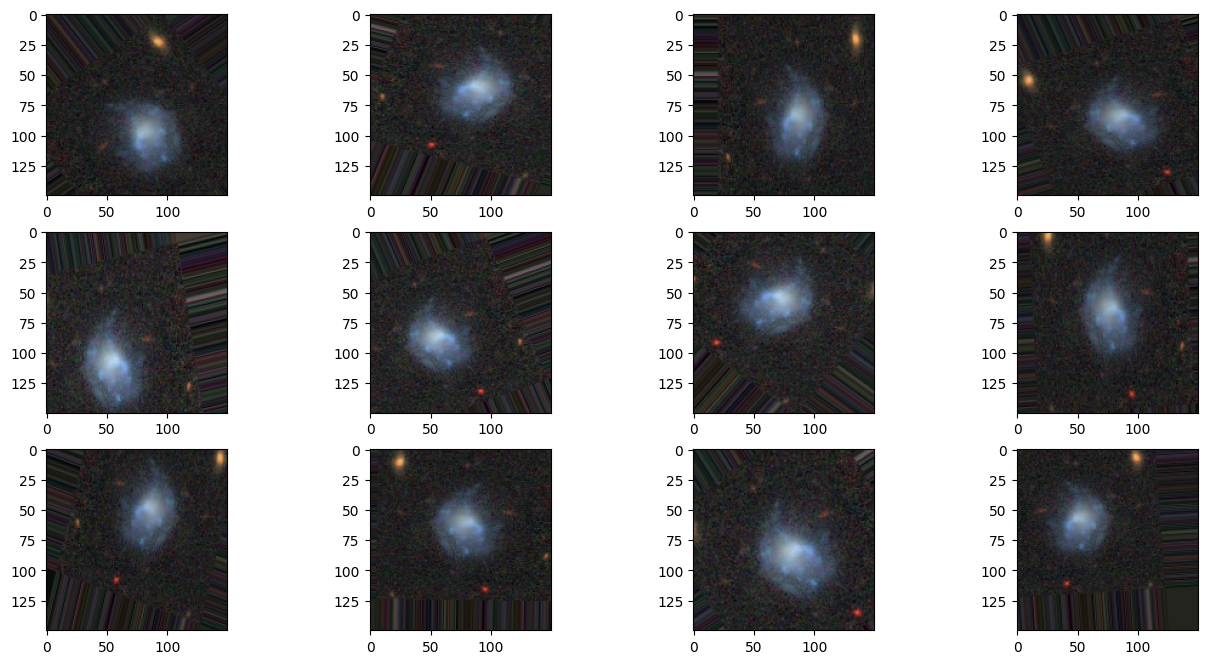

In [17]:
#@title Zbiór treningowy DIsturbed:
idx = 131 #@param {type:'slider', min:0, max:919}
display_augmented_images('/content/dataset/train/0', idx)

In [18]:
batch_size = 32
steps_per_epoch = 4898 // batch_size
validation_steps = 1399 // batch_size

img.size

(256, 256)

In [19]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
      print(f'layer name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
layer name: input_layer   trainable: True
layer name: block1_conv1  trainable: True
layer name: block1_conv2  trainable: True
layer name: block1_pool   trainable: True
layer name: block2_conv1  trainable: True
layer name: block2_conv2  trainable: True
layer name: block2_pool   trainable: True
layer name: block3_conv1  trainable: True
layer name: block3_conv2  trainable: True
layer name: block3_conv3  trainable: True
layer name: block3_conv4  trainable: True
layer name: block3_pool   trainable: True
layer name: block4_conv1  trainable: True
layer name: block4_conv2  trainable: True
layer name: block4_conv3  trainable: True
layer name: block4_conv4  trainable: True
layer name: block4_pool   trainable: True
layer name: block5_conv1  trainable: True
layer name: block5_conv2  trainable: True
layer name: block5_conv3  trainable: True
layer name: block5_conv4  trainable: True
layer name: block5_pool   trainable: True


In [20]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
      set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer name: input_layer   trainable: False
layer name: block1_conv1  trainable: False
layer name: block1_conv2  trainable: False
layer name: block1_pool   trainable: False
layer name: block2_conv1  trainable: False
layer name: block2_conv2  trainable: False
layer name: block2_pool   trainable: False
layer name: block3_conv1  trainable: False
layer name: block3_conv2  trainable: False
layer name: block3_conv3  trainable: False
layer name: block3_conv4  trainable: False
layer name: block3_pool   trainable: False
layer name: block4_conv1  trainable: True
layer name: block4_conv2  trainable: True
layer name: block4_conv3  trainable: True
layer name: block4_conv4  trainable: True
layer name: block4_pool   trainable: True
layer name: block5_conv1  trainable: True
layer name: block5_conv2  trainable: True
layer name: block5_conv3  trainable: True
layer name: block5_conv4  trainable: True
layer name: block5_pool   trainable: True


In [21]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,005,127 (125.90 MB)

 Trainable params: 30,678,535 (117.03 MB)

 Non-trainable params: 2,326,592 (8.88 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 50,
                    validation_data = valid_generator,
                    validation_steps = validation_steps,
                    callbacks = early_stopping)

Epoch 1/50
  5/153 ━━━━━━━━━━━━━━━━━━━━ 2:01:40 49s/step - accuracy: 0.1513 - loss: 2.5519

In [ ]:
import plotly.graph_objects as go

def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size = (224, 224),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=-1)

In [ ]:
y_pred

In [ ]:
predictions = pd.DataFrame(y_pred, columns=['Class number'])
predictions

In [ ]:
y_true = test_generator.classes
y_true

In [ ]:
y_pred = predictions['Class number'].values
y_pred

In [ ]:
classes = list(test_generator.class_indices.keys())
classes

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

In [ ]:
def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    # Ręczne napisy
    annotations = [[str(val) for val in row] for row in cm.values]

    fig = ff.create_annotated_heatmap(
        z=cm.values,
        x=list(cm.columns),
        y=list(cm.index),
        annotation_text=annotations,
        colorscale='ice',
        showscale=True,
        reversescale=True
    )

    fig.update_layout(
        width=900,          # szerszy
        height=900,         # wyższy
        title='Confusion Matrix',
        font_size=12        # mniejsza czcionka
    )

    fig.show()


In [ ]:
plot_confusion_matrix(cm)